In [11]:
import os
os.path.abspath("")

'C:\\Users\\alexa\\Taller1-SistemasDeRecomendacion'

In [42]:
import os
import numpy as np
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
import random 

#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)

In [43]:
useridprofile = pd.read_csv('userid-profile.tsv', sep='\t')

In [44]:
file2 = pd.read_csv('userid-timestamp-artid-artname-traid-traname.tsv',sep='\t', nrows= 1000000, header=None,names=[
    "userid",
    "timestamp",  
    "musicbrainz-artist-id", 
    "artist-name",
    "artist-name musicbrainz-track-id", 
    "track-name",
]) 

In [45]:
type(useridprofile)

pandas.core.frame.DataFrame

In [46]:
useridprofile.head()

,#id,gender,age,country,registered
0,user_000001,m,NaN,Japan,"Aug 13, 2006"
1,user_000002,f,NaN,Peru,"Feb 24, 2006"
2,user_000003,m,22.0,United States,"Oct 30, 2005"
3,user_000004,f,NaN,NaN,"Apr 26, 2006"
4,user_000005,m,NaN,Bulgaria,"Jun 29, 2006"


In [47]:
file2.head(100)

,userid,timestamp,musicbrainz-artist-id,artist-name,artist-name musicbrainz-track-id,track-name
0,user_000001,2009-05-04T23:08:57Z,f1b1cf71-bd35-4e99-8624-24a6e15f133a,Deep Dish,NaN,Fuck Me Im Famous (Pacha Ibiza)-09-28-2007
1,user_000001,2009-05-04T13:54:10Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Composition 0919 (Live_2009_4_15)
2,user_000001,2009-05-04T13:52:04Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc2 (Live_2009_4_15)
3,user_000001,2009-05-04T13:42:52Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Hibari (Live_2009_4_15)
4,user_000001,2009-05-04T13:42:11Z,a7f7df4a-77d8-4f12-8acd-5c60c93f4de8,坂本龍一,NaN,Mc1 (Live_2009_4_15)
...,...,...,...,...,...,...
95,user_000001,2009-05-01T08:58:19Z,NaN,Ivan Enot,NaN,Grooves Of The Heart
96,user_000001,2009-05-01T08:52:36Z,1e68e986-e1f7-42ef-be43-086c858db02e,J. Boogie'S Dubtronic Science,66eb69ab-a5e3-4d17-92a6-754c898e4c86,Leave It All Behind (Feat. The Rebirth & Aima ...
97,user_000001,2009-05-01T08:45:19Z,c2fc3098-b9a5-41ab-b897-e6d67b097dfa,Home & Garden,820c1ffc-5a54-4d68-9603-765b83531578,Someday (Feat. Lisa Shaw)
98,user_000001,2009-05-01T08:41:49Z,278db520-adb6-4d27-a770-7539fa2e33b7,Kissey Asplund,NaN,Move Me [Feat. Soliloquy]


In [48]:
matriz = file2[["userid","track-name"]]

In [49]:
matriz.columns

Index(['userid', 'track-name'], dtype='object')

In [50]:
matriz.shape

(1000000, 2)

In [51]:
matriz.groupby(['userid'])['userid'].agg({'count'}).sort_values(by='count',ascending=False)

,count
userid,
user_000033,96436
user_000012,75876
user_000021,70446
user_000002,57438
user_000022,51474
user_000026,45308
user_000023,42010
user_000029,41830
user_000025,39082


In [52]:
df_count = matriz.groupby(['userid','track-name'], as_index=True)['track-name'].agg({'count'}).sort_values(by='count',ascending=False)

In [53]:
df_count.head()

count
userid      track-name                                   
user_000008 Heartless                                2119
            See You In My Nightmares                 2069
            Say You Will                             2065
            Love Lockdown                            2059
            Welcome To Heartbreak (Feat. Kid Cudi)   2059

In [54]:
type(df_count)

pandas.core.frame.DataFrame

In [55]:
df_count.columns

Index(['count'], dtype='object')

## Construcción de modelos colaborativos usuario-usuario

In [56]:
df2 = matriz.groupby(['userid','track-name'],as_index=False)['track-name'].agg({'count'}).reset_index()

In [57]:
df2[['userid', 'track-name']] = df2[['userid', 'track-name']].astype(str)

In [58]:
df2.dtypes

userid        object
track-name    object
count          int64
dtype: object

In [59]:
df2[df2['userid'] == 'user_000033'].shape

(6902, 3)

In [60]:
df2[df2['userid'] == 'user_000033'].sort_values(by='count',ascending=False)

,userid,track-name,count
175581,user_000033,Ryoujoku No Ame,880
171505,user_000033,Ain'T Afraid To Die,855
173723,user_000033,Itoshii Hito,753
176008,user_000033,Somnus Memoria,730
173931,user_000033,Kekkonshiki No Uta ~Kisetsu Hazure No Wedding ...,630
...,...,...,...
175986,user_000033,So Sad So Bad,1
175987,user_000033,So...,1
173134,user_000033,Gozen 0 Toki Ni Torauma Radio - Shiwase Na Hibi,1
173133,user_000033,Gozen 0 Ji No Abangyarudo,1


In [61]:
#We have to normalized "count" to make it in the form of our modele with ranking between 1 and 5
#Count Column represent the max of listening of a user for a single track
maxs = df2.groupby(['userid']).max().reset_index()
maxs.head(10)

,userid,track-name,count
0,user_000001,Ｔouch - A Mountain Of One Peyote Remix,70
1,user_000002,…,139
2,user_000003,[Untitled],47
3,user_000004,黒い涙 -Tv Live Edition-,308
4,user_000005,Що Ли Те Чакам Още,355
5,user_000006,Яппи - Гоу Хоум!,107
6,user_000007,¢Hunk Up Da Duece,22
7,user_000008,Život Napsal Sám (Feat. Jay Diesel),2119
8,user_000009,テイク 5,29
9,user_000010,_The_Dj_Was_My_Father_(Tom_Do,377


## Rating normalized creation

In [62]:
rating_normalized = []

n = len(df2['userid'])

df_userid = df2['userid']
df_count = df2['count'].tolist()

for i in range(n):
    
    userId =  df_userid[i]
    
    max_user_items = maxs[maxs['userid'] == userId]['count'].iloc[0]
    
    #Rating normalized between 0 and 5
    rating_normalized.append(5 * (df_count[i]) / max_user_items)
    
for i in range(n):
    
    #Rating normalized between 1 and 5
    rating_normalized[i] = (4*rating_normalized[i] + 5)/5
        
df2['rating_normalized'] = rating_normalized
print("Done")

Done


In [63]:
df2['rating_normalized'] = df2['rating_normalized'].astype(float)
display(df2.dtypes)

userid                object
track-name            object
count                  int64
rating_normalized    float64
dtype: object

In [64]:
df2.head(100)

,userid,track-name,count,rating_normalized
0,user_000001,'84 Pontiac Dream,14,1.800000
1,user_000001,(All I Wanted Was To Make You) Feel Good,3,1.171429
2,user_000001,(D)Ecaying Beauty,1,1.057143
3,user_000001,(Far From) Home,1,1.057143
4,user_000001,(Get Off Your) High Horse Lady,1,1.057143
...,...,...,...,...
95,user_000001,Air Vibes,1,1.057143
96,user_000001,Akropolis,7,1.400000
97,user_000001,"Al-Falaq 113 Featuring Mino Cinelu, Gene Lake,...",1,1.057143
98,user_000001,Alarm Call,4,1.228571


In [65]:
df2[df2['userid'] == 'user_000033'].sort_values(by='count',ascending=False)

,userid,track-name,count,rating_normalized
175581,user_000033,Ryoujoku No Ame,880,5.000000
171505,user_000033,Ain'T Afraid To Die,855,4.886364
173723,user_000033,Itoshii Hito,753,4.422727
176008,user_000033,Somnus Memoria,730,4.318182
173931,user_000033,Kekkonshiki No Uta ~Kisetsu Hazure No Wedding ...,630,3.863636
...,...,...,...,...
175986,user_000033,So Sad So Bad,1,1.004545
175987,user_000033,So...,1,1.004545
173134,user_000033,Gozen 0 Toki Ni Torauma Radio - Shiwase Na Hibi,1,1.004545
173133,user_000033,Gozen 0 Ji No Abangyarudo,1,1.004545


# Ahora construyamos la matriz de utilidad

In [1132]:
#mu = Matrix de Utilidad segun el usuario i

#Create of Column of index in useridprofile
useridprofile['index'] = range(len(useridprofile))

def matrix_utilidad(i):
    '''Return the matrix of utility of the user i'''
    
    #Take the userId name of the user i
    userid = useridprofile.loc[useridprofile['index'] == i, '#id'].iloc[0]
    print("UserId : " + userid)
    
    #Select the tracks associated with user i
    tracks_ui = df2.loc[df2['userid'] == userid, ['userid','track-name']]
    #onlytrack_ui.drop_duplicates(keep = 'first', inplace = True)
    tracks_ui['index'] = range(len(tracks_ui))
    nb_track = len(tracks_ui)
    
    #Select the neighbour of user i
    neighbour_ui = df2[df2['track-name'].isin(tracks_ui['track-name'])]
    nb_neighbour = len(neighbour_ui['userid'].drop_duplicates(keep = 'first', inplace = False))

    print("Tenemos " + str(nb_neighbour - 1) + " usuarios vecinos")
    print("Tenemos " + str(nb_track) + " tracks")

    #Create the matrix of utility
    mu = np.zeros((nb_neighbour, nb_track))
    
    user_i_row = []

    for k in neighbour_ui.index:
        
        #Get userid and track of the k-row of neighbour_ui
        useridk = neighbour_ui.loc[k, 'userid']
        tracknamek = neighbour_ui.loc[k, 'track-name']
        
        #Get index of user and track associated with this userid and track
        num_user = useridprofile.loc[useridprofile['#id'] == useridk, 'index'].iloc[0]
        num_track = tracks_ui.loc[tracks_ui['track-name'] == tracknamek, 'index'].iloc[0]
        
        #Add the value of rating normalized in the matrix of utility
        if (num_user < i):
            mu[num_user+1][num_track] = neighbour_ui.loc[k, 'rating_normalized']
            
        elif (num_user > i):
            mu[num_user][num_track] = neighbour_ui.loc[k, 'rating_normalized']
            
        else : 
            user_i_row.append(neighbour_ui.loc[k, 'rating_normalized'])
            
    #The user i is always the first row of the matrix of utility
    mu[0] = np.array(user_i_row)

    mu2 = np.array(mu)
    
    return mu2


In [1133]:
matrix_utilidad(1)

UserId : user_000002
Tenemos 40 usuarios vecinos
Tenemos 8129 tracks


array([[1.05755396, 1.05755396, 1.05755396, ..., 1.05755396, 1.08633094,
        1.05755396],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Vamos a determinar los simitudes entre el usuario x y los otros

In [1121]:
def similitudes(x, mu):
    '''Return similitudes of user X with the other users'''
    
    #Read the row of mu for user x to calculate his norm of rating
    usarioX = mu[0] 
    norm_uX = np.sqrt(np.dot(usarioX, usarioX))

    #Create the list of similarities between user x and the other users
    sim = []

    for i in range(1, len(mu)):
    
        #Calculate the similarity between user x and user i
        scal = np.dot(usarioX, mu[i])
        norm_ui = np.sqrt(np.dot(mu[i], mu[i]))
        
        sim_coseno = 0
        if not ((norm_uX == 0) or (np.isnan(norm_uX)) or (norm_ui == 0) or (np.isnan(norm_ui))):
            sim_coseno = scal / (norm_uX * norm_ui)
        
        sim.append([sim_coseno, i])
        
    return sim
    

## Vamos a hacer predicciones de relevancia con un modelo basado en distancias coseno

In [1183]:
def prediccion(i, j, mu, sim, index_model):
    '''Return the value of prediction predicted for user i and item j according to the matrix of utility mu of i'''
    
    sum1 = 0
    
    for k in range(len(sim)):
        
        #Calculate the first sum of the formula for prediction
        #bkj = np.mean(mu[sim[k][1]]) + np.mean(np.transpose(mu)[j]) - np.mean(mu)
        bkj = np.mean(mu[sim[k][1]])
        sum1 += sim[k][0]*(mu[sim[k][1]][j] - bkj) 
    
    #Calculate the sum of similarities to normalize sum1
    sum2 = np.sum(np.array(sim[:][0]))
    
    #baseline estimate for Muij
    #bij = np.mean(mu[0]) + np.mean(np.transpose(mu)[j]) - np.mean(mu)
    bij = np.mean(mu[0]) 
    
    #Calculate finale prediction
    pred = bij + (sum1/sum2)
    print("La predicción para el usuario " + str(i) + " y para el item " + str(j) + " es: " + str(pred))
    print("El real rating of item " + str(j) + " por el usuario " + str(i) + " is " + str(mu[0][j]))

    return pred



In [ ]:
#Test prediccion

mui = matrix_utilidad(1)
sim = similitudes(1, mui)
pred = prediccion(0, 0, mui, sim, 0)


## Vamos a medir la cualidad de esos predicciones

In [1190]:
import time as t

def funcion_costo(n, m, pred_fct, sim_fct, index_model):
    '''Return the value of cost function for n users and m items'''
    
    # n = Number of users for test
    # m = Number of items for test

    start = t.time()

    #Evaluamos sus distancias con el funcion costo quien es proportional a la distancia euclidian entre las prediccions y las datas
    funcion_costo = 0

    for i in range(n):
    
        mu = np.array([[]])
        if(index_model == 0):
            mu = matrix_utilidad(i)
        else:
            mu = matrix_utilidad2(i)
            
        sim = sim_fct(i, mu)
        
        N = min(len(mu[0]), m)
        
        for j in range(N):
            
            pred = pred_fct(i, j, mu, sim, index_model)
            
            #We use the mean quadratic error to calculate our cost function
            funcion_costo += (pred - mu[0][j])**2

    funcion_costo = funcion_costo / (2*n*m)

    tiempo = t.time() - start
    print("\nTiempo de ejecucion : " + str(tiempo))
    
    if(index_model == 0):
         print("Modelo collaborativo usuario-usuario")
    else:
         print("Modelo collaborativo item-item")

   
    print("El function de costo o la cualidad de esos predicciones es de : " + str(funcion_costo))
    
    return tiempo, funcion_costo

In [1191]:
#Test value of cost function for cosine similitude
tiempo1, funcion_costo1 = funcion_costo(3, 3, prediccion, similitudes, 0)

UserId : user_000001
Tenemos 40 usuarios vecinos
Tenemos 3092 tracks
La predicción para el usuario 0 y para el item 0 es: 2.7431625503837016
El real rating of item 0 por el usuario 0 is 1.8
La predicción para el usuario 0 y para el item 1 es: 1.184708729032642
El real rating of item 1 por el usuario 0 is 1.1714285714285713
La predicción para el usuario 0 y para el item 2 es: 0.998570115185475
El real rating of item 2 por el usuario 0 is 1.0571428571428572
UserId : user_000002
Tenemos 40 usuarios vecinos
Tenemos 8129 tracks
La predicción para el usuario 1 y para el item 0 es: 0.6955904921182867
El real rating of item 0 por el usuario 1 is 1.0575539568345325
La predicción para el usuario 1 y para el item 1 es: 0.22541831789189792
El real rating of item 1 por el usuario 1 is 1.0575539568345325
La predicción para el usuario 1 y para el item 2 es: 0.22541831789189792
El real rating of item 2 por el usuario 1 is 1.0575539568345325
UserId : user_000003
Tenemos 40 usuarios vecinos
Tenemos 4565

In [1137]:
#Test to compare the best item recommended for user 0 and the real rating of this item
def compareBestItem(i, pred):
    userid = useridprofile.loc[useridprofile['index'] == i, '#id'].iloc[0]
    onlytrack_ui = df2.loc[df2['userid'] == userid, ['userid','track-name', 'rating_normalized']]
    onlytrack_ui['index'] = range(len(onlytrack_ui))
    nb_track = len(onlytrack_ui)

    mu = matrix_utilidad(i)
    sim = similitudes(i, mu)

    best_pred_value = 0
    best_pred_id = 0

    for j in range(nb_track):

        predj = pred(i, j, mu, sim)

        if predj > best_pred_value:
            best_pred_value = predj
            best_pred_id = j

    best_pred_track = onlytrack_ui.loc[onlytrack_ui['index'] == best_pred_id]
    print("Final best prediction is the track n°" + str(best_pred_id) + " : " + str(best_pred_track['track-name']))

    real_best_item = onlytrack_ui.sort_values(by='rating_normalized',ascending=False).iloc[j]
    print("Real best prediction is the track n°" + str(real_best_item['index']) + " : " + str(real_best_item['track-name']))
    
    error = 100 * (5 - real_best_item['rating_normalized']) / 5
    print("\n\nThe error of prediction is : " + str(round(error, 2)) + " %")
    
    return error


In [199]:
compareBestItem(0, prediccion)

UserId : user_000001
Tenemos 40 usuarios vecinos
Tenemos 3092 tracks
Final best prediction is the track n°1218 : 1218    Intro
Name: track-name, dtype: object
Real best prediction is the track n°3091 : Ｔouch - A Mountain Of One Peyote Remix


The error of prediction is : 78.86 %


78.85714285714286

In [724]:
mu = matrix_utilidad(0)
sim = similitudes(0, mu)
print(sim)

UserId : user_000001
Tenemos 40 usuarios vecinos
Tenemos 3092 tracks
[0.23442635853842195, 0.1781162646905488, 0.22891378251557773, 0.1348245354201449, 0.22628779635810156, 0.08175935678932303, 0.07043049035789263, 0.13217364826146577, 0.0851459263718719, 0.177948398792549, 0.2818870379917326, 0.1812023414805475, 0.04449516475942248, 0.1182094935426211, 0.2439769935078927, 0.2427626028085268, 0.12115201210097612, 0.18398732968379095, 0.16690074893742068, 0.18099544503660536, 0.14779945801933303, 0.1310384209635869, 0.27340939620371263, 0.236249617000209, 0.1993910180483349, 0.08056247552462212, 0.17907011973930378, 0.26868743296566044, 0.21851858850521735, 0.3189456085772271, 0.12542395767763317, 0.2177813127092301, 0.18119491985149067, 0.1533500590694796, 0.15334194853525676, 0.21932477439977185, 0.12233559848951868, 0.10685034379113664, 0.16467383417351825, 0.19386445534856675]


## Nueva estrategia de seleccion de vecinos por umbral de similitud y por numero de vecinos

In [1192]:
import copy as c

def mejor_prediccion1(i,j, mu, sim, index_model):
    '''Return the prediction of user i and item j with selection of neighbour'''
    
    #Neighborhood selection
    #Max(N) = 10 para modelo usuario-usuario
    #Max(N) = 1000 para modelo item-item
    
    N = 0
    
    if(index_model == 0):
        N = min(len(sim), 10)
    else:
        N = min(len(sim), 1000)
    
    #better_sim = c.deepcopy(sim)
    better_sim = [list(s) for s in sim]
    better_sim.sort()
    better_sim = better_sim[::-1]
    better_sim = better_sim[:N]

    pred = 0
    
    #Calculate finale prediction with better_sim
    if(N != 0):
        pred = prediccion(i, j, mu, better_sim, index_model)  
    else:
        pred = prediccion(i, j, mu, sim, index_model)
    
    return pred

In [1193]:
#Test value of cost function with better similitudes
tiempo2, funcion_costo2 = funcion_costo(3, 3, mejor_prediccion1, similitudes, 0)

UserId : user_000001
Tenemos 40 usuarios vecinos
Tenemos 3092 tracks
La predicción para el usuario 0 y para el item 0 es: 1.362359377057807
El real rating of item 0 por el usuario 0 is 1.8
La predicción para el usuario 0 y para el item 1 es: 1.3010072554006509
El real rating of item 1 por el usuario 0 is 1.1714285714285713
La predicción para el usuario 0 y para el item 2 es: 1.3010072554006509
El real rating of item 2 por el usuario 0 is 1.0571428571428572
UserId : user_000002
Tenemos 40 usuarios vecinos
Tenemos 8129 tracks
La predicción para el usuario 1 y para el item 0 es: 1.1955485424439993
El real rating of item 0 por el usuario 1 is 1.0575539568345325
La predicción para el usuario 1 y para el item 1 es: 1.1780311187169585
El real rating of item 1 por el usuario 1 is 1.0575539568345325
La predicción para el usuario 1 y para el item 2 es: 1.1780311187169585
El real rating of item 2 por el usuario 1 is 1.0575539568345325
UserId : user_000003
Tenemos 40 usuarios vecinos
Tenemos 4565 

In [ ]:
compareBestItem(0, mejor_prediccion1)

In [1194]:
def mejor_prediccion2(i, j, mu, sim, index_model):
    '''Like better_prediccion1 but with a strategy of ponderation of McLaughlin'''

    #Use make case amplification of very similar neighbors
    #The threshold to select very similar neighbors is when neighbors have more than 150 items in common
    #Alpha = 150 encontra empiricamente para modelo usuario-usuario
    alpha = 0
    
    if(index_model == 0):
        alpha = 150
    else:
        alpha = 3
    
    mejor_sim = []
        
    nb_user = len(mu)
    nb_item = len(mu[0])
    
    sim_copy = [list(s) for s in sim]

    for k in range(1, nb_user):
        
        nb_common_item = 0
        for l in range(nb_item):
            if(mu[k][l] != 0.):
                nb_common_item += 1
                
        mejor_sim_value = max(nb_common_item, alpha)*sim[k-1][0] / alpha
        mejor_sim.append([mejor_sim_value, sim[k-1][1]])
    
    pred =  mejor_prediccion1(i, j, mu, mejor_sim, index_model)

    
    return pred

In [1195]:
#Test value of cost function with ponderation of McLaughlin
tiempo3, funcion_costo3 = funcion_costo(3, 3, mejor_prediccion2, similitudes, 0)

UserId : user_000001
Tenemos 40 usuarios vecinos
Tenemos 3092 tracks
La predicción para el usuario 0 y para el item 0 es: 1.4092976399234158
El real rating of item 0 por el usuario 0 is 1.8
La predicción para el usuario 0 y para el item 1 es: 1.2969293068105614
El real rating of item 1 por el usuario 0 is 1.1714285714285713
La predicción para el usuario 0 y para el item 2 es: 1.2969293068105614
El real rating of item 2 por el usuario 0 is 1.0571428571428572
UserId : user_000002
Tenemos 40 usuarios vecinos
Tenemos 8129 tracks
La predicción para el usuario 1 y para el item 0 es: 1.1268379469049918
El real rating of item 0 por el usuario 1 is 1.0575539568345325
La predicción para el usuario 1 y para el item 1 es: 1.0053359744950305
El real rating of item 1 por el usuario 1 is 1.0575539568345325
La predicción para el usuario 1 y para el item 2 es: 1.0053359744950305
El real rating of item 2 por el usuario 1 is 1.0575539568345325
UserId : user_000003
Tenemos 40 usuarios vecinos
Tenemos 4565

In [1021]:
mu_test = matrix_utilidad(0)
sim_test = similitudes(0, mu)

In [1022]:
def test(num_item):
    
    test0 = prediccion(0, num_item, mu_test, sim_test, 0)
    print("Prediccion : " + str(test0))
    test1 = mejor_prediccion1(0, num_item, mu, sim_test, 0)
    print("Mejor Prediccion 1 : " + str(test1))
    test2 = mejor_prediccion2(0, num_item, mu, sim_test, 0)
    print("Mejor Prediccion 2 : " + str(test2))
    test3 = mu[0][num_item]
    print("Real Value : " + str(test3))
    return

In [1142]:
for i in range(5):
    test(i)

Prediccion : 2.7431625503837016
Mejor Prediccion 1 : 1.3667711605573352
Mejor Prediccion 2 : 1.413659756306291
Real Value : 1.8
Prediccion : 1.184708729032642
Mejor Prediccion 1 : 1.3033192021522766
Mejor Prediccion 2 : 1.299219198688113
Real Value : 1.1714285714285713
Prediccion : 0.998570115185475
Mejor Prediccion 1 : 1.2957406268864617
Mejor Prediccion 2 : 1.2917402794831092
Real Value : 1.0571428571428572
Prediccion : 1.3256847546743604
Mejor Prediccion 1 : 1.309058996808094
Mejor Prediccion 2 : 1.305487330445487
Real Value : 1.0571428571428572
Prediccion : 1.378989289895357
Mejor Prediccion 1 : 1.3112292742364693
Mejor Prediccion 2 : 1.3108067787451991
Real Value : 1.0571428571428572


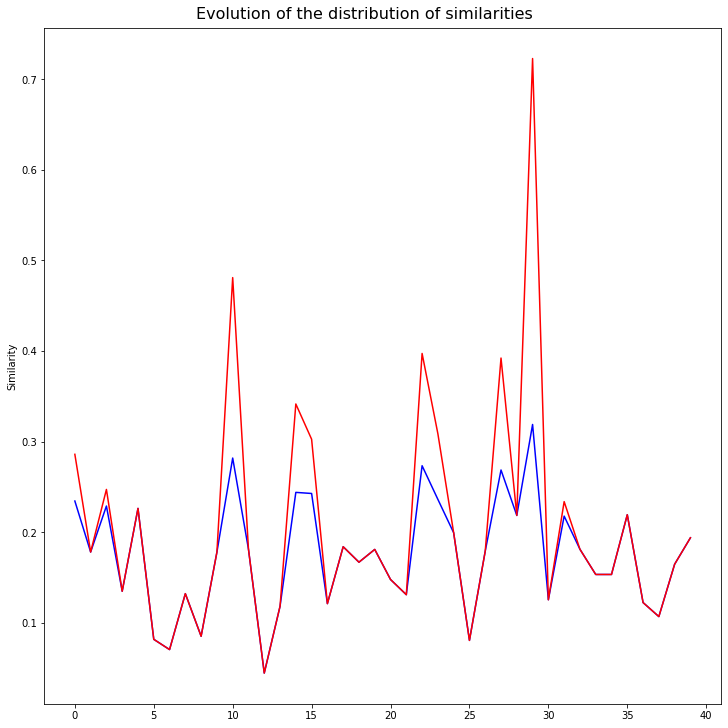

In [1025]:
#Visual representation of the change of similarities made by mejor_prediccion2

import matplotlib.pyplot as plt

#Alpha = 150 encontra empiricamente
alpha = 150

x = np.arange(len(sim))
y1 = []
y2 = []
  
nb_user = len(mu)
nb_item = len(mu[0])
    
for i in range(1, nb_user):
        
    nb_common_item = 0
    for j in range(nb_item):
        if(mu[i][j] != 0):
            nb_common_item += 1
                
    y1.append(sim[i-1][0])
    
    mejor_sim_value = max(nb_common_item, alpha)*sim[i-1][0] / alpha
    y2.append(mejor_sim_value)

fig, axe = plt.subplots(constrained_layout = True,figsize=(10,10))

plt.plot(x, y1, 'b') #BLUE COLOR FOR NORMAL SIMILARITIES
plt.plot(x, y2, 'r') #RED COLOR FOR AFTER APPLYING PONDERATION OF MACLAUGHIN

axe.set_ylabel("Similarity")
fig.suptitle("Evolution of the distribution of similarities", fontsize=16);

plt.show()



### Visual Comparison between model with and without selection of neighbour and similiraties amplification

In [1143]:
#pip install --upgrade matplotlib
#import matplotlib.pyplot as plt

def muestra(a, b, c):
    '''muestra un gráfico de barras de los valores de la función de costo en cada paso de la mejora de la estrategia de predicción'''
    
    cualidad_analyse = {
        'Standart Model': (a),
        'Neighbour Selection': (b), 
        'Neighbour Selection + Similarity Amplification': (c)
    }

    cases = np.array([a, b, c])

    x = np.arange(len(cases))
    widthBar = 1
    multiplier = 0

    fig, axe = plt.subplots(constrained_layout = True,figsize=(10,10))
    

    #Pantalla gráfica para comparar el rendimiento y la cualidad

    for sim, measurement in cualidad_analyse.items():
        offset = widthBar * multiplier
        bar1 = axe.bar(offset, height = measurement, width = widthBar, label=sim)
        multiplier += 1


    axe.set_ylabel("Function de costo")
    axe.set_xticks(x)
    axe.set_xticklabels(cases)
    axe.legend(loc='upper left')
    fig.suptitle("Analisis de la cualidad de similitudes cosenos para un modelo collaborativo usuario-usuario", fontsize=16);
                
    plt.show()
    return

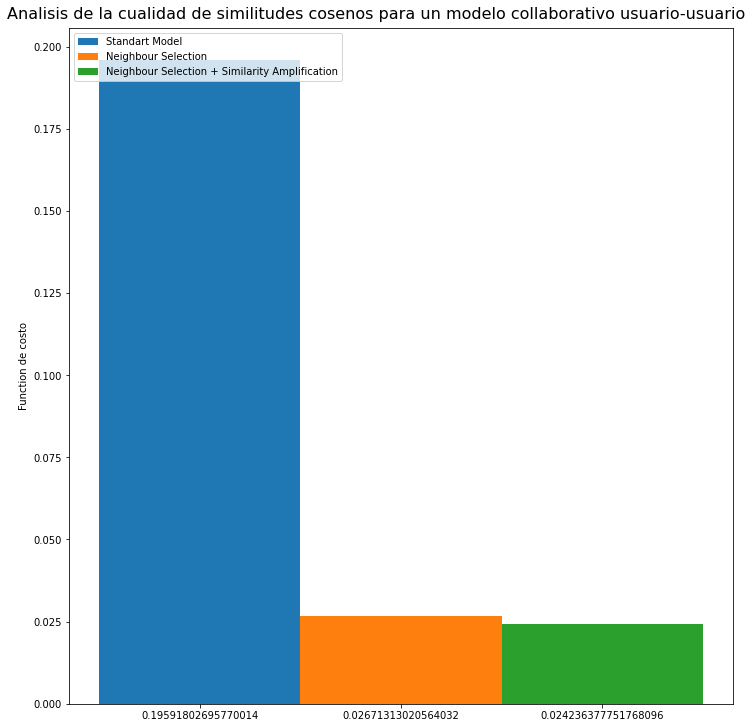

In [1196]:
#print("PREDICCION NORMALE :")
#tiempo1, funcion_costo1 = funcion_costo(3, 3, prediccion, similitudes, 0)
#print("MEJOR PREDICCION 1 :")
#tiempo2, funcion_costo2 = funcion_costo(3, 3, mejor_prediccion1, similitudes, 0)
#print("MEJOR PREDICCION 2 :")
#tiempo3, funcion_costo3 = funcion_costo(3, 3, mejor_prediccion2, similitudes, 0)

muestra(funcion_costo1, funcion_costo2, funcion_costo3)

## Lo mismo para un modelo colaborativo item-item

In [1187]:
#mu2 = Matrix de Utilidad segun el item i

def matrix_utilidad2(i):
    '''Return the matrix of utility of the user i'''
    
    #Create dataframe of only tracks
    track_df = pd.DataFrame(df2['track-name'].drop_duplicates(keep = 'first', inplace = False), columns=['track-name'])
    track_df['index'] = range(len(track_df))
    
    #Take the trackId name of the item i
    trackname = track_df.loc[track_df['index'] == i, 'track-name'].iloc[0]
    print("TrackID : " + trackname)
    
    #Select the users associated with item i
    users_ti = df2.loc[df2['track-name'] == trackname, ['track-name','userid']]
    users_ti['index'] = range(len(users_ti))
    nb_users = len(users_ti)
    
    #Select the neighbour of item i
    neighbour_ti = df2[df2['userid'].isin(users_ti['userid'])]
    nb_neighbour = len(neighbour_ti['track-name'].drop_duplicates(keep = 'first', inplace = False))
    #neighbour_ti['index'] = range(len(neighbour_ti))
    
    track_df = track_df.loc[track_df['track-name'].isin(neighbour_ti['track-name'])]
    track_df['index'] = range(len(track_df))
    
    print("Tenemos " + str(nb_neighbour - 1) + " tracks vecinos")
    print("Tenemos " + str(nb_users) + " users")

    #Create the matrix of utility
    mu2 = np.zeros((nb_neighbour, nb_users))
    
    track_i_row = []
    

    for k in neighbour_ti.index:
        
        #Get itemid and user of the k-row of neighbour_ui
        useridk = neighbour_ti.loc[k, 'userid']
        tracknamek = neighbour_ti.loc[k, 'track-name']
        
        #print("TEST X")
        #print(tracknamek)
        
        #Get index of user and track associated with this userid and track
        num_track = track_df.loc[track_df['track-name'] == tracknamek, 'index'].iloc[0]
        num_user = users_ti.loc[users_ti['userid'] == useridk, 'index'].iloc[0]
        
        
        #Add the value of rating normalized in the matrix of utility
        if (num_track < i):
            mu2[num_track+1][num_user] = neighbour_ti.loc[k, 'rating_normalized']
            
        elif (num_track > i):
            if(num_track == 39932):
                print("STOP")
            mu2[num_track][num_user] = neighbour_ti.loc[k, 'rating_normalized']
            
        else : 
            track_i_row.append(neighbour_ti.loc[k, 'rating_normalized'])
            
    #The item i is always the first row of the matrix of utility
    mu2[0] = np.array(track_i_row)
    
    return np.array(mu2)

In [1159]:
matrix_utilidad2(1)

TrackID : (All I Wanted Was To Make You) Feel Good
Tenemos 7328 tracks vecinos
Tenemos 2 users


array([[1.17142857, 1.15238095],
       [1.8       , 0.        ],
       [1.05714286, 0.        ],
       ...,
       [0.        , 1.03809524],
       [0.        , 2.1047619 ],
       [0.        , 1.01904762]])

In [1197]:
tiempo4, funcion_costo4 = funcion_costo(1, 5, prediccion, similitudes, 1)

TrackID : '84 Pontiac Dream
Tenemos 39931 tracks vecinos
Tenemos 5 users
La predicción para el usuario 0 y para el item 0 es: -3127.149745997544
El real rating of item 0 por el usuario 0 is 1.8
La predicción para el usuario 0 y para el item 1 es: 3567.249346824167
El real rating of item 1 por el usuario 0 is 3.347107438016529
La predicción para el usuario 0 y para el item 2 es: -1321.1628983605037
El real rating of item 2 por el usuario 0 is 1.0597014925373134
La predicción para el usuario 0 y para el item 3 es: -2965.738562712214
El real rating of item 3 por el usuario 0 is 1.342857142857143
La predicción para el usuario 0 y para el item 4 es: 3856.317043557444
El real rating of item 4 por el usuario 0 is 1.9655172413793103

Tiempo de ejecucion : 256.14602160453796
Modelo collaborativo item-item
El function de costo o la cualidad de esos predicciones es de : 4789959.6128906


In [1198]:
#Parametrize N = 1000 for the number of neighbour considered
tiempo5, funcion_costo5 = funcion_costo(1, 5, mejor_prediccion1, similitudes, 1)

TrackID : '84 Pontiac Dream
Tenemos 39931 tracks vecinos
Tenemos 5 users
La predicción para el usuario 0 y para el item 0 es: 1.6857514543877277
El real rating of item 0 por el usuario 0 is 1.8
La predicción para el usuario 0 y para el item 1 es: 2.2006297463504874
El real rating of item 1 por el usuario 0 is 3.347107438016529
La predicción para el usuario 0 y para el item 2 es: 1.7790123743188326
El real rating of item 2 por el usuario 0 is 1.0597014925373134
La predicción para el usuario 0 y para el item 3 es: 1.7315491794447742
El real rating of item 3 por el usuario 0 is 1.342857142857143
La predicción para el usuario 0 y para el item 4 es: 2.1182405602884753
El real rating of item 4 por el usuario 0 is 1.9655172413793103

Tiempo de ejecucion : 238.95900988578796
Modelo collaborativo item-item
El function de costo o la cualidad de esos predicciones es de : 0.20192778837569927


In [1199]:
#Parametrize alpha = 3 for the number of user in common
tiempo6, funcion_costo6 = funcion_costo(1, 5, mejor_prediccion2, similitudes, 1)

TrackID : '84 Pontiac Dream
Tenemos 39931 tracks vecinos
Tenemos 5 users
La predicción para el usuario 0 y para el item 0 es: 1.6653011506615039
El real rating of item 0 por el usuario 0 is 1.8
La predicción para el usuario 0 y para el item 1 es: 2.189998336384574
El real rating of item 1 por el usuario 0 is 3.347107438016529
La predicción para el usuario 0 y para el item 2 es: 1.7814072919038202
El real rating of item 2 por el usuario 0 is 1.0597014925373134
La predicción para el usuario 0 y para el item 3 es: 1.7490369316625787
El real rating of item 3 por el usuario 0 is 1.342857142857143
La predicción para el usuario 0 y para el item 4 es: 2.129439604177821
El real rating of item 4 por el usuario 0 is 1.9655172413793103

Tiempo de ejecucion : 241.40109515190125
Modelo collaborativo item-item
El function de costo o la cualidad de esos predicciones es de : 0.20697570757913483


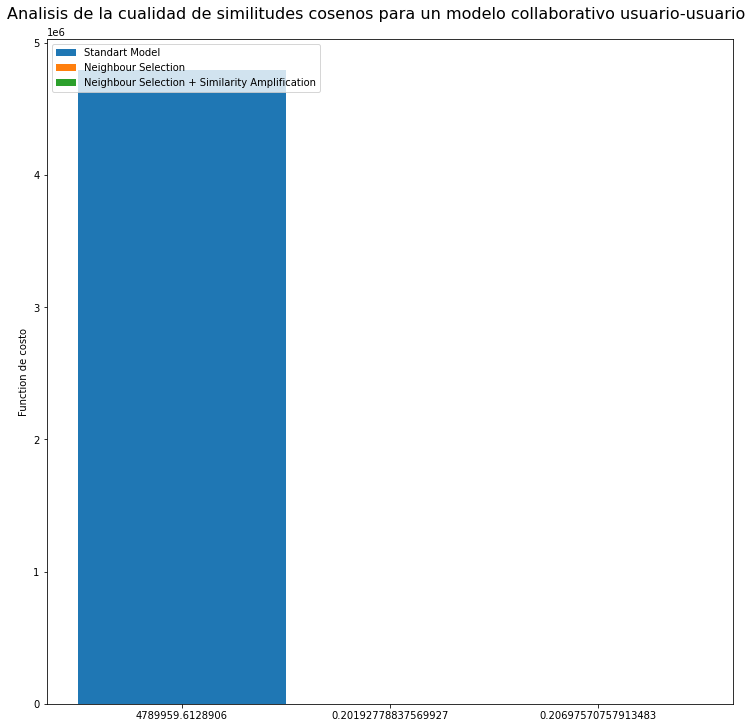

In [1200]:
muestra(funcion_costo4, funcion_costo5, funcion_costo6)

### Analysis Modelo ITEM ITEM
#### Podemos ver que cuando el tamaño de los vecinos es mas importante, la valor del funcion de costo (Prediction normale) sea mas importante  Entonces, es muy importante de poner filtros como vecinos selecion o similaridad amplificacion para mejorar este funcion de costo, pues nuestro sistema de recommendacion